In [47]:
import torch
from torch import nn, optim
from torchvision import transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [48]:
class MultiOutputModel(nn.Module):
    def __init__(self, num_types, num_rarities, num_colors):
        super().__init__()
        # Chargement correct du backbone
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        self.fc_type = nn.Linear(in_features, num_types)
        self.fc_rarity = nn.Linear(in_features, num_rarities)
        self.fc_colors = nn.Linear(in_features, num_colors)

    def forward(self, x):
        features = self.backbone(x)
        return self.fc_type(features), self.fc_rarity(features), self.fc_colors(features)
        # On enlève la sigmoïd pour pouvoir observer les gradients (non-aplatis)
    

def get_transforms(img_size=256):
    """Retourne les transformations d'images"""
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [49]:
def visualize_multi_outputs(model, input_tensor, rgb_img):
    # On prend la dernière couche convolutive
    target_layers = [model.backbone.features[8][0]]
    
    # Wrapper pour récup la caractéristique désirée
    class OutputWrapper(torch.nn.Module):
        def __init__(self, model, index):
            super().__init__()
            self.model = model
            self.index = index
        def forward(self, x):
            return self.model(x)[self.index]

    titles = ['Type', 'Rarity', 'Colors']
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Afficher l'image originale
    axes[0].imshow(rgb_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Générer la heatmap pour chaque caractéristique
    for i in range(3):
        wrapped_model = OutputWrapper(model, i)
        
        cam = GradCAM(model=wrapped_model, target_layers=target_layers)
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
        
        # Superposition sur l'image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        axes[i+1].imshow(visualization)
        axes[i+1].set_title(f"Focus: {titles[i]}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def process_and_visualize(model, image_path, img_size=256):
    model.eval()
    
    # Charge l'image originale et rezise)
    orig_img = Image.open(image_path).convert('RGB')
    orig_img = orig_img.resize((img_size, img_size))
    rgb_img = np.float32(orig_img) / 255
    
    
    transform = get_transforms(img_size)
    input_tensor = transform(orig_img).unsqueeze(0) # Ajoute la dimension batch
    
    visualize_multi_outputs(model, input_tensor, rgb_img)



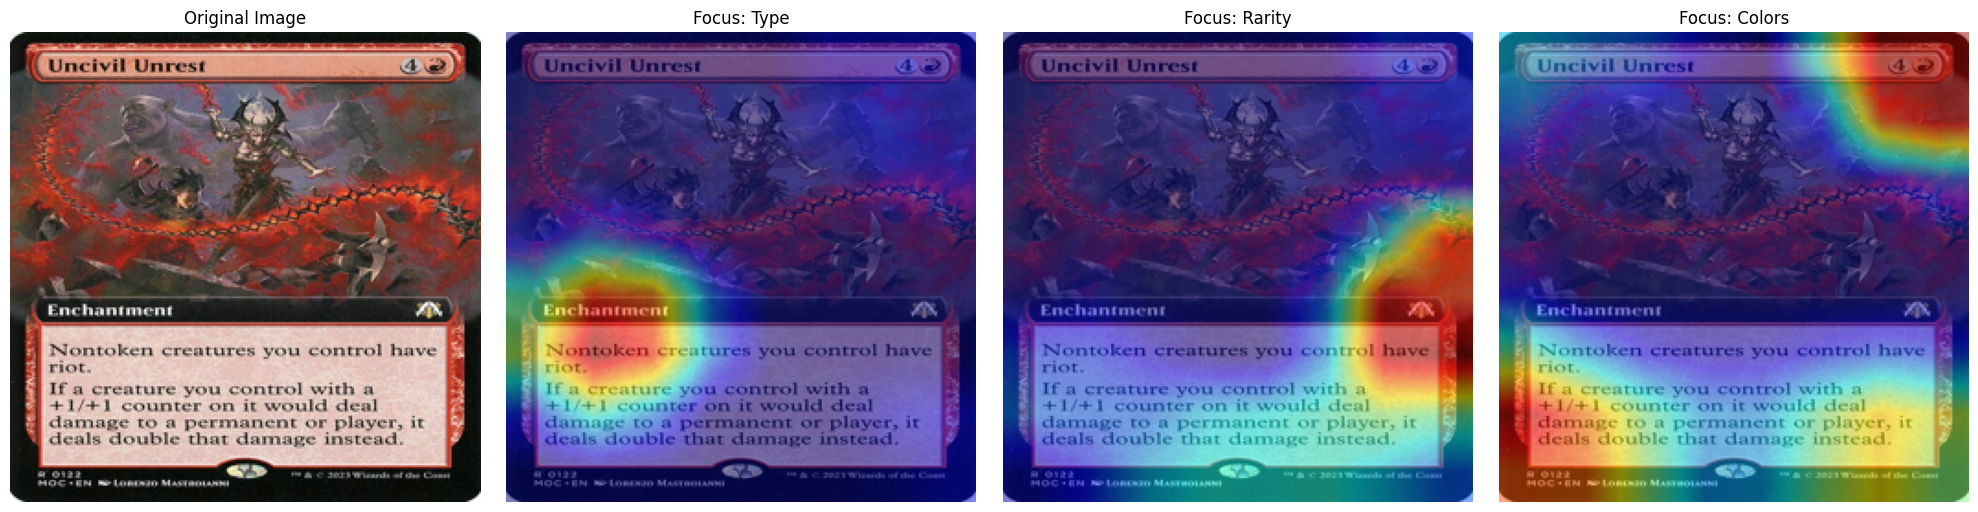

In [54]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = "saved_models\\best_model_30.pth"
CLASS_NAMES_PATH = "class_names.json"
OUTPUT_DIR = "heatmaps_output"
NUM_COLORS = 6  # White, Blue, Black, Red, Green, Colorless
NUM_TYPES = 7
NUM_RARITIES = 5


model = MultiOutputModel(NUM_TYPES, NUM_RARITIES, NUM_COLORS)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
process_and_visualize(model, "mtg_dataset\\test\\0a9e1b5e-233e-4066-9d03-d04a051d8cfb.jpg")